The first step is to set up the directories. Obviously, you'll need somewhere to store the ouput.

In [1]:
from pathlib import Path
import yaml

root_dir = Path("/media") / "sharedData" / "data"
orig_mosaic_dir = root_dir / "archival" / "grizli-v2" / "JwstMosaics" / "v7"
out_base_dir = root_dir / "2024_08_16_A2744_v4" / "glass_niriss"

out_base_dir.mkdir(exist_ok=True, parents=True)

The next step is to parse all of the imaging mosaics. We need to have some record of:
* Which combination of telescope, instrument, and filter corresponds to each image.
* The type of each image - science, weight, exposure, variance.

If your imaging mosaics follow the Grizli AWS / DJA format, there's an automated function to parse this information from a directory. We can also loop over each instrument/filter key to calculate the full variance mosaic (including the poisson noise).

<div class="alert alert-warning">

**Warning:**

Calculating the full variance array can require a significant amount of memory and disk space, particularly if the mosaics are very large, or are stored in compressed ".fits.gz" format. Even parsing information from the FITS header can take a long time if the files are compressed.

</div>


In [2]:
# Where to save the details
obs_dict_path = out_base_dir / "full_ancillary_data.yaml"

# Avoid parsing files again if the details already exist 
if obs_dict_path.is_file():
    
    with open(obs_dict_path, "r") as file:
        obs_dict = yaml.safe_load(file)

else:

    from glass_niriss.pipeline import parse_files_grizli_aws

    obs_dict = parse_files_grizli_aws(
        orig_mosaic_dir, out_path=out_base_dir / "full_ancillary_data.yaml"
    )

In [3]:
# Check that a variance array exists for all science images
for k, v in obs_dict.items():
    if v.get("var") is None:
        try:
            var_path = Path(v["exp"]["path"].replace("_exp", "_var"))
            assert var_path.is_file(), "var does not exist" 
        except:
            print (f"Generating var for {k}...")
            
            from glass_niriss.isophotal import calc_full_var

            try:
                var_path = calc_full_var(
                    sci_path=v["sci"]["path"], wht_path=v["wht"]["path"],
                    exp_path=v["exp"]["path"]
                )
                obs_dict[k]["var"] = {
                    "path" : str(var_path),
                    "version" : v["exp"]["version"],
                    "flag_incomplete" : v["exp"]["flag_incomplete"]
                }
            except:
                print (f"Failed to generate var for {k}")

with open(obs_dict_path, "w") as outfile:
    yaml.dump(obs_dict, outfile, default_flow_style=False, sort_keys=False)

       

Before we can start using these images, we want to make sure they're all aligned, at the right pixel scale, and with the same point-spread function (PSF). To do this, we need to know the PSF of each individual image. Deriving this is not (currently) part of the ``glass-niriss`` package, although PSFs for the A2744 field are included under ``data/psfs``. Some packages and useful references for deriving PSFs include [aperpy](https://github.com/astrowhit/aperpy), [photutils](https://photutils.readthedocs.io), and [PSFEx](https://psfex.readthedocs.io).

Opening ``"full_ancillary_data.yaml"`` in any suitable text editor, you'll notice there's an empty field marked ``psf`` for each filter key. Simply copy and paste the path to the relevant PSF here, and then carry on running the pipeline.

<div class="alert alert-warning">

**Warning:**

As before, the reprojection and convolution **will** require a significant amount of memory and disk space. Depending on how many filters you have, it could also take a couple hours (*eg* A2744: 38 filters, 43k x 35k mosaics -> 1.2 hours). The good news is, you only have to run this code block once.

</div>

In [4]:
from glass_niriss.isophotal import reproject_and_convolve

# Reload the full obs dict with PSF info
with open(obs_dict_path, "r") as file:
    obs_dict = yaml.safe_load(file)

# Where to save the details of the PSF-matched images
conv_dict_path = out_base_dir / "conv_ancillary_data.yaml"

# Where to save the reprojected and convolved images
conv_out_dir = out_base_dir / "PSF_matched_data"

# The reference mosaic to align the images to
ref_mosaic = (
    root_dir / "2023_11_07_spectral_orders" / "Prep" / "nis-wfss-ir_drz_sci.fits"
)

# Avoid parsing files again if the details already exist 
if conv_dict_path.is_file():

    with open(obs_dict_path, "r") as file:
        conv_dict = yaml.safe_load(file)

else:
    conv_dict = {}
    for filt_key, old_details in obs_dict.items():
        conv_dict[filt_key] = {
            k: v for k, v in old_details.items() 
            if k not in ["exp","sci","var","wht"]
        }

        for t in ["sci","var"]:
            _conv_out_path = reproject_and_convolve(
                ref_path=ref_mosaic,
                orig_images=Path(obs_dict[filt_key][t]["path"]),
                psfs=Path(obs_dict[filt_key]["psf"]),
                psf_target=obs_dict["jwst-nircam-f444w"]["psf"],
                out_dir=conv_out_dir,
                new_names=f"repr_{filt_key}_{t}.fits",
                reproject_image_kw={"method": "adaptive", "compress": False,},
            )

            conv_dict[filt_key][t] = str(_conv_out_path[0])

print (conv_dict)

(5022, 5130)
{'method': 'adaptive', 'compress': False}
/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/repr_hst-acs-f435w_sci.fits
'repr_hst-acs-f435w_sci.fits' already exists. Set `overwrite=True` if you wish to overwrite this file.
'conv_hst-acs-f435w_sci.fits' already exists. Skipping.
(5022, 5130)
{'method': 'adaptive', 'compress': False}
/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/repr_hst-acs-f435w_var.fits
'repr_hst-acs-f435w_var.fits' already exists. Set `overwrite=True` if you wish to overwrite this file.
'conv_hst-acs-f435w_var.fits' already exists. Skipping.
(5022, 5130)
{'method': 'adaptive', 'compress': False}
/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/repr_hst-acs-f475w_sci.fits
'repr_hst-acs-f475w_sci.fits' already exists. Set `overwrite=True` if you wish to overwrite this file.
'conv_hst-acs-f475w_sci.fits' already exists. Skipping.
(5022, 5130)
{'method': 'adaptive', 'compress': False}


We now have a directory of flux and variance images, PSF-matched to our largest PSF, and aligned to a consistent pixel scale. Let's do the same to our segmentation map.

In [5]:
# The path of the original segmentation map
orig_seg = root_dir / "2023_11_07_spectral_orders" / "Prep" / "nis-wfss-ir_seg.fits"

reproject_and_convolve(
    ref_path=ref_mosaic,
    orig_images=orig_seg,
    psfs=None,
    psf_target=None,
    out_dir=conv_out_dir,
    new_names="repr_seg_map.fits",
    reproject_image_kw={"method": "interp", "order": 0, "compress" : False},
)

repr_seg_path = conv_out_dir / "repr_seg_map.fits"

(5022, 5130)
{'method': 'interp', 'order': 0, 'compress': False}
/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/repr_seg_map.fits
'repr_seg_map.fits' already exists. Set `overwrite=True` if you wish to overwrite this file.


That's everything we need to start deriving spatially-resolved SEDs. Let's pull out an interesting object to look at.

[2685 2685 2685 ... 2777 2778 2778]
{'filt': 'F200W', 'pupil': 'CLEAR', 'detector': 'NRCA1', 'instrument': 'NIRCAM', 'telescope': 'JWST', 'psf': '/media/sharedData/data/archival/grizli-v2/JwstMosaics/v7/UNCOVER_DR3_PSFs/f200w_psf_norm.fits', 'sci': '/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/conv_jwst-nircam-f200w_sci.fits', 'var': '/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/conv_jwst-nircam-f200w_var.fits'}


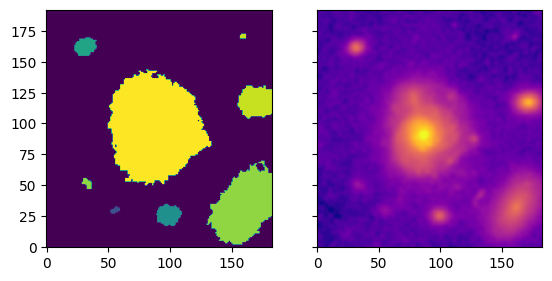

In [6]:
from astropy.io import fits
from astropy import visualization as astrovis
import matplotlib.pyplot as plt

from glass_niriss.pipeline import seg_slice

# Choose a filter to use
sn_filter = "jwst-nircam-f200w"

# A nice extended object, located behind the cluster
obj_id = 2495
obj_z = 1.3397

# Open the segmentation map
with fits.open(repr_seg_path) as repr_seg_hdul:
    repr_seg_map = repr_seg_hdul[0].data

    # Convenience function to find the location of the object
    obj_img_idxs = seg_slice(repr_seg_map, obj_id)

    print (conv_dict[sn_filter])

    with fits.open(
        conv_dict[sn_filter]["sci"]
    ) as img_hdul:

        norm = astrovis.ImageNormalize(
            img_hdul[0].data[obj_img_idxs],
            interval=astrovis.PercentileInterval(99.9),
            stretch=astrovis.LogStretch(),
        )

        fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
        axs[0].imshow(repr_seg_map[obj_img_idxs]%13)
        axs[1].imshow(img_hdul[0].data[obj_img_idxs], norm=norm, origin="lower", cmap="plasma")
        plt.show()

There's many different ways to go about this. Some authors prefer to fit every pixel, some perform an adaptive binning across the whole image to ensure a minimum signal/noise (S/N). For very large galaxies, there's a ``constrained_adaptive()`` function, where the initial binning is done in a hexagonal pattern, and any remaining pixels are run through an adaptive Voronoi binning scheme. This can ensure a minimum bin size (avoiding significant oversampling of the PSF), as well as reducing the number of bins to fit.

For this particular galaxy, given its small size, we just run through a Voronoi binning method ``constrained_adaptive(..., use_hex=False)``. We aim for a S/N of 100, and mask out pixels that aren't included in the segmentation map for this object.

/tmp/ipykernel_329895/2852717782.py:9: RuntimeWarning: invalid value encountered in sqrt
  noise = np.sqrt(fits.getdata(conv_dict[sn_filter]["var"]))[obj_img_idxs]


Skipping hex
Bin-accretion...
1  /  442
2  /  442
3  /  442
4  /  442
5  /  442
6  /  442
7  /  442
8  /  442
9  /  442
10  /  442
11  /  442
12  /  442
13  /  442
14  /  442
15  /  442
16  /  442
17  /  442
18  /  442
19  /  442
20  /  442
21  /  442
22  /  442
23  /  442
24  /  442
25  /  442
26  /  442
27  /  442
28  /  442
29  /  442
30  /  442
31  /  442
32  /  442
33  /  442
34  /  442
35  /  442
36  /  442
37  /  442
38  /  442
39  /  442
40  /  442
41  /  442
42  /  442
43  /  442
44  /  442
45  /  442
46  /  442
47  /  442
48  /  442
49  /  442
50  /  442
51  /  442
52  /  442
53  /  442
54  /  442
55  /  442
56  /  442
57  /  442
58  /  442
59  /  442
60  /  442
61  /  442
62  /  442
63  /  442
64  /  442
65  /  442
66  /  442
67  /  442
68  /  442
69  /  442
70  /  442
71  /  442
72  /  442
73  /  442
74  /  442
75  /  442
76  /  442
77  /  442
78  /  442
79  /  442
80  /  442
81  /  442
82  /  442
83  /  442
84  /  442
85  /  442
86  /  442
87  /  442
88  /  442
89  /  442


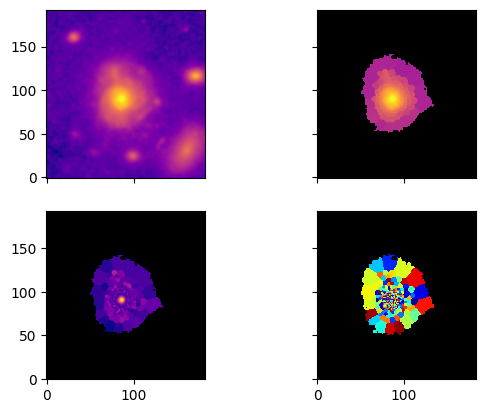

In [7]:
from glass_niriss.sed import constrained_adaptive
import numpy as np

target_sn = 100

signal = fits.getdata(conv_dict[sn_filter]["sci"])[obj_img_idxs]

# Don't forget that the noise is the square root of the variance array
noise = np.sqrt(fits.getdata(conv_dict[sn_filter]["var"]))[obj_img_idxs]

# Only use voronoi binning
hexbin = False
bin_diameter = 0

bin_labels, nbins, bin_sn, bin_inv = constrained_adaptive(
    signal=signal,
    noise=noise,
    target_sn=target_sn,
    mask = repr_seg_map[obj_img_idxs]!=obj_id,
    use_hex=False,
    plot=True
)

And finally, we can save the segmentation map, along with the binned data for all filters.

In [8]:
from glass_niriss.sed import save_binned_data

# Make a new directory for the binned data
bin_data_dir = out_base_dir / "binned_data"
bin_data_dir.mkdir(exist_ok=True, parents=True)

# Give it a meaningful name - this avoids confusion if rerunning with multiple configurations
binned_name = f"{obj_id}_{"hexbin" if hexbin else "vorbin"}_{bin_diameter}_{target_sn}"

if not (bin_data_dir / f"{binned_name}_data.fits").is_file():
    save_binned_data(
        bin_labels=bin_labels,
        out_path=bin_data_dir / f"{binned_name}_data.fits",
        filter_keys=[*conv_dict.keys()],
        signal_paths=[conv_dict[f]["sci"] for f in conv_dict.keys()],
        var_paths=[conv_dict[f]["var"] for f in conv_dict.keys()],
        crop=obj_img_idxs
    )

If you're working with multiple objects, there's also a convenient wrapper for these operations. Using a slightly different object:

[3396 3396 3396 ... 3450 3451 3451]
Skipping hex
Bin-accretion...
1  /  57
2  /  57
3  /  57
4  /  57
5  /  57
6  /  57
7  /  57
8  /  57
9  /  57
10  /  57
11  /  57
12  /  57
13  /  57
14  /  57
15  /  57
16  /  57
17  /  57
18  /  57
19  /  57
20  /  57
21  /  57
22  /  57
23  /  57
24  /  57
25  /  57
26  /  57
27  /  57
28  /  57
29  /  57
30  /  57
31  /  57
32  /  57
33  /  57
34  /  57
35  /  57
36  /  57
37  /  57
38  /  57
39  /  57
40  /  57
41  /  57
42  /  57
43  /  57
44  /  57
45  /  57
46  /  57
47  /  57
48  /  57
49  /  57
50  /  57
51  /  57
52  /  57
53  /  57
54  /  57
55  /  57
56  /  57
57  /  57
58  /  57
59  /  57
60  /  57
61  /  57
62  /  57
63  /  57
64  /  57
65  /  57
66  /  57
67  /  57
68  /  57
69  /  57
70  /  57
71  /  57
72  /  57
73  /  57
74  /  57
75  /  57
76  /  57
77  /  57
78  /  57
79  /  57
80  /  57
81  /  57
82  /  57
83  /  57
84  /  57
85  /  57
86  /  57
87  /  57
88  /  57
89  /  57
90  /  57
91  /  57
92  /  57
93  /  57
94  /  57
95 

/media/sharedData/python/py3.12_GLASS_pipeline/code/GLASS-NIRISS/src/glass_niriss/sed/binning.py:546: RuntimeWarning: invalid value encountered in sqrt
  noise = np.sqrt(fits.getdata(info_dict[sn_filter]["var"]))[obj_img_idxs]


Iter:   22  Diff: 0.1683
Iter:   23  Diff: 0.2272
Iter:   24  Diff: 0.2324
Iter:   25  Diff: 0.282
Iter:   26  Diff: 0.06217
25  iterations.
Unbinned pixels:  0  /  2448
Fractional S/N scatter (%): 10.26097759747565
Elapsed time accretion: 0.09 seconds
Elapsed time optimization: 0.03 seconds
Total bins: 54 (Hex: 0, Voronoi: 53)


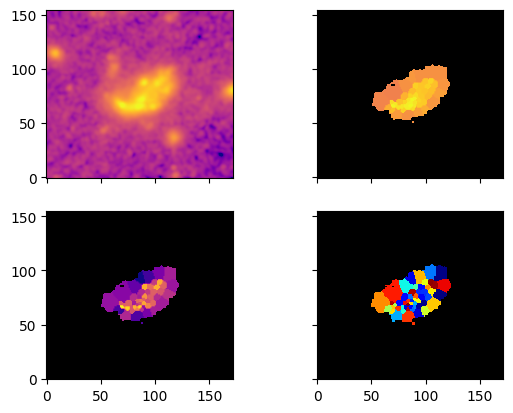

bin_id bin_area ... jwst-niriss-f200w_sci jwst-niriss-f200w_var
------ -------- ... --------------------- ---------------------
     0    24212 ...    14.936048933983539    15.328851124250118
     1       10 ...     7.059911235057801   0.01254305656671929
     2       33 ...     6.611280559803648   0.02726617223885743
     3      228 ...    17.829842091334164   0.15926226936301296
     4       14 ...     6.485612949861642  0.014534588775598625
     5      245 ...    17.381336490573467   0.17243419339252514
     6       10 ...     5.745491040271525  0.011355423288058674
     7       30 ...     8.482617843399824  0.026073166835187827
     8       20 ...     5.368500230668992  0.017762906022754852
     9       41 ...     8.767180715567136  0.032597911670836456
   ...      ... ...                   ...                   ...
    44       34 ...     8.793809773960529   0.02838476803068631
    45       26 ...     8.102435494211713   0.02355223732158119
    46       24 ...     9.27860249608892

In [9]:
from glass_niriss.sed import bin_and_save

bin_and_save(
    obj_id = 3217,
    out_dir = bin_data_dir,
    seg_map = repr_seg_map,
    info_dict = conv_dict,
    sn_filter = "jwst-nircam-f200w",
    target_sn=50
)